# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

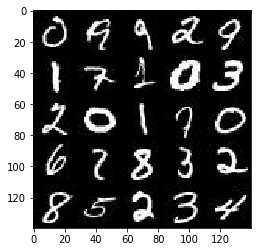

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

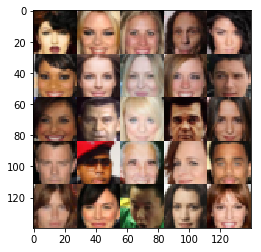

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [72]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # Real input images placeholder with rank 4 using image_width, image_height, and image_channels.
    inputs_real = tf.placeholder(tf.float32, (None,image_width, image_height, image_channels), name='input_real')
    
    # Z input placeholder with rank 2 using z_dim.
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    # Learning rate placeholder with rank 0.
    learn_rate  = tf.placeholder(tf.float32,name='learning_rate')
    return inputs_real, inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [73]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Use tf.variable_scope with a scope name of "discriminator" to allow the variables to be reused.
    # 
    # In the 2016 ICLR conference paper entitled "Unsupervised Representational
    # Learning with Deep Convolutional Generative Adversarial Networks", authors
    # Radford, Metz, and Chintala introduce DCGANs to the literature, and provide
    # guidance on architectural topology and hyperparameter settings.
    # See especially Sections 3 and 4 of the paper.
    # Regarding the discriminator, Radford et al. suggest replacing any pooling
    # layers with strided convolutions, using batch normalization, removing
    # fully connected hidden layers, and using Leaky ReLUs.
    alpha = 0.2 # Radford et al. set the leak slope to 0.2 (Section 4).
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer can be either 28x28x1 [MNIST] or 28x28x3 [CelebA]
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1) # Leaky ReLU
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2) # Leaky ReLU
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3) # Leaky ReLU
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1,4*4*256))
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [74]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # Use tf.variable_scope with a scope name of "generator" to allow the variables to be reused.
    # 
    # In the 2016 ICLR conference paper entitled "Unsupervised Representational
    # Learning with Deep Convolutional Generative Adversarial Networks", authors
    # Radford, Metz, and Chintala introduce DCGANs to the literature, and provide
    # guidance on architectural topology and hyperparameter settings.
    # See especially Sections 3 and 4 of the paper.
    # Regarding the generator, Radford et al. suggest replacing any pooling
    # layers with fractional-strided convolutions, using batch normalization,
    # removing fully connected hidden layers, and using ReLU activation for all
    # layers except for the output, which uses Tanh.
    # According to the following two web pages
    # https://stackoverflow.com/questions/39373230/what-does-tensorflows-conv2d-transpose-operation-do
    # https://datascience.stackexchange.com/questions/6107/what-are-deconvolutional-layers
    # transpose convolution is the same thing as fractional-strided convolution,
    # and is the new (and better) name for what used to be called "deconvolution"
    # ("deconvolution" means recovering a filter kernel in signal processing, which
    # is something different from what we're doing here!).
    alpha = 0.2 # Radford et al. set the leak slope to 0.2 (Section 4).
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)

        # Reshape it to start the convolutional stack
        # Note that Radford et al. did NOT use leakly ReLUs in their generators,
        # but they were used in the DCGAN notebook. I will try Leaky ReLUs here.
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1) # Leaky ReLU
        # 7x7x512 now

        # Note use of transpose convolution (fractional convolution).
        # I had been wondering whether we ought to be using nearest
        # neighbor upsampling instead, to avoid checkerboard pattern
        # artifacts. Cf. the Convolutional Autoencoder notebook.
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2) # Leaky ReLU
        # 14x14x256 now

        # Second transpose convolution.
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28xout_channel_dim now

        out = tf.tanh(logits)

    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [75]:
def model_loss(input_real, input_z, out_channel_dim, smooth = 0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Implement model_loss to build the GANs for training and calculate the loss.
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # Compute sigmoid cross-entropy from the logits.
    # 
    # In the 2016 ICLR conference paper entitled "Unsupervised Representational
    # Learning with Deep Convolutional Generative Adversarial Networks", authors
    # Radford, Metz, and Chintala introduce DCGANs to the literature, and provide
    # guidance on architectural topology and hyperparameter settings.
    # See especially Sections 3 and 4 of the paper. Radford et al. say nothing
    # about using label smoothing with DCGANs. Maybe label smoothing is a
    # more recent invention.
    #d_loss_real = tf.reduce_mean(
    #    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    # Below is commented out code for label smoothing, which is an alternative
    # computation for D_LOSS_REAL. I am not using label smoothing at this time.
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*(1-smooth)))

    # Compute total discriminator loss as the sum of losses from real and fake images.
    d_loss = d_loss_real + d_loss_fake

    # Return a tuple of (discriminator loss, generator loss)
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [76]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Filter the variables with names that are in the discriminator and generator scope names.
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    # On the Slack channel, pradau wrote "The other trick is
    # to put the control_dependencies only around the generator
    # optimizer (instead of both like in the DCGAN lesson)."
    # (See pradau's post on 5/31/2017 at 11:47 AM.)
    # I will give that idea a try here.
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    # pradau further wrote "I don’t understand this function well..."
    # I am similarly using it here without fully understanding it.
    # It is another TensorFlow subtlety I will need to study further.
 
    # The function should return a tuple of (discriminator training operation, generator training operation).
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [77]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [104]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model. Use the following functions you implemented:
    # model_inputs(image_width, image_height, image_channels, z_dim)
    # model_loss(input_real, input_z, out_channel_dim)
    # model_opt(d_loss, g_loss, learning_rate, beta1)
    # I get an error "IndexError: list index out of range"
    # at the very end of iterating over epochs if I use
    # tf.reset_default_graph; my impression is that
    # it is due to some strange iteraction with
    # tf.global_variables_initializer() (maybe it is a
    # TensorFlow bug?). For that reason, I have commented
    # out tf.reset_default_graph() here.
    #tf.reset_default_graph()
    out_channel_dim = data_shape[3]
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)

    # Select between three optimization strategies.
    # (1) Basic approach, which is to optimize both the generator and
    #     the discriminator as was done in the DCGAN notebook.
    # (2) Conditional optimization using a "controller" (Siraj's term).
    # (3) Optimize the generator twice as often as the discriminator.
    # All three strategies seem to work okay, although only the third
    # strategy seems to (fairly consistently) cause the final loss
    # of the generator to be lower than that of the discriminator.
    # Select between the three strategies by setting
    # OPTIMIZATIONSTRATEGY to 1, 2, or 3 in the following line.
    optimizationStrategy = 3
    print("############################################################")
    if optimizationStrategy == 1:
        print("Basic optimization")
    elif optimizationStrategy == 2:
        print("Optimizing using a controller")
        train_loss_d = 0 # Initial value
        train_loss_g = 1 # Initial value
    else:
        print("Optimizing the generator twice as often as the discriminator")
    print("############################################################")

    # Perform training.
    batch_count = round(data_shape[0]/batch_size) # Number of batches per epoch
    num_batches = 0 # Number of batches ACROSS epochs
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_j = 0 # Number of batches WITHIN epoch
            for batch_images in get_batches(batch_size):
                # Keep track of the number of batches
                batch_j += 1     # Number of batches WITHIN epoch
                num_batches += 1 # Number of batches ACROSS epochs

                # As per information in the Preprocess the Data section,
                # the values of the MNIST and CelebA images will be in
                # the range of -0.5 to 0.5 of 28x28 dimensional images.
                # Multiply them by 2 to bring them to the range of [-1,1].
                # The generator output is from the TANH function, so it
                # has a theoretical range of [-1,1].
                batch_images = 2 * batch_images

                # Sample random noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers. I have tried three different strategies.
                if optimizationStrategy == 1:
                    # Basic optimization strategy. Cf. the DCGAN notebook.
                    _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                    _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                elif optimizationStrategy == 2:
                    # I tried the idea of using an optimization CONTROLLER,
                    # i.e., conditional optimization where one selectively trains
                    # either the discriminator or the generator if one or the other
                    # is doing badly.
                    # See Siraj's implementation of a "controller" in his EZGAN
                    # notebook from his YouTube presentation.
                    # https://github.com/llSourcell/Generative_Adversarial_networks_LIVE
                    # My implementation here isn't identical to Siraj's, but it's the
                    # same general idea.
                    if train_loss_d > train_loss_g:
                        _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    # We want the loss of the generator to be less than the loss
                    # of the discriminator. Also, the threshold of 0.5 is what
                    # Siraj used for conditionally optimizating the generator.
                    if train_loss_g > train_loss_d or train_loss_g > 0.5:
                        _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                else:
                    # Here I am trying the idea of optimizing the generator
                    # TWICE for every optimizing of the discriminator.
                    # See pradau's comment posted 5/31/2017 at 11:46 AM.
                    # https://nd101.slack.com/archives/C3QVCQHGW/p1496245571139666
                    _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                    _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                    # Second round of optimization for the generator. I am guessing that it
                    # is good to provide the generator with a fresh vector of random numbers.
                    batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim)) # Fresh random numbers
                    _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                # Show losses every 10 batches.
                if num_batches % 10 == 0:
                    # Get the losses and print them out.
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Batch {}/{}, Epoch {}/{}...".format(batch_j,batch_count,epoch_i+1,epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                # It's recommended to print the generator output every 100 batches.
                # I will also show generator output after the very last batch.
                if num_batches % 100 == 0 or num_batches == batch_count:
                    # Show generator output.
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
            

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

############################################################
Optimizing the generator twice as often as the discriminator
############################################################
Batch 10/400, Epoch 1/2... Discriminator Loss: 2.3265... Generator Loss: 0.2451
Batch 20/400, Epoch 1/2... Discriminator Loss: 2.2036... Generator Loss: 0.6319
Batch 30/400, Epoch 1/2... Discriminator Loss: 2.0503... Generator Loss: 0.3914
Batch 40/400, Epoch 1/2... Discriminator Loss: 1.7003... Generator Loss: 0.7276
Batch 50/400, Epoch 1/2... Discriminator Loss: 1.9357... Generator Loss: 0.6414
Batch 60/400, Epoch 1/2... Discriminator Loss: 1.7049... Generator Loss: 0.7667
Batch 70/400, Epoch 1/2... Discriminator Loss: 1.8049... Generator Loss: 0.4971
Batch 80/400, Epoch 1/2... Discriminator Loss: 1.5870... Generator Loss: 0.8450
Batch 90/400, Epoch 1/2... Discriminator Loss: 1.3921... Generator Loss: 0.8193
Batch 100/400, Epoch 1/2... Discriminator Loss: 1.6673... Generator Loss: 0.4379


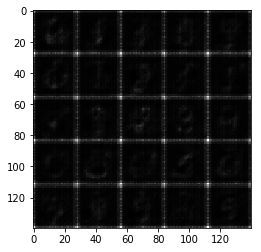

Batch 110/400, Epoch 1/2... Discriminator Loss: 1.6019... Generator Loss: 0.5597
Batch 120/400, Epoch 1/2... Discriminator Loss: 1.3322... Generator Loss: 0.9214
Batch 130/400, Epoch 1/2... Discriminator Loss: 1.3147... Generator Loss: 0.7440
Batch 140/400, Epoch 1/2... Discriminator Loss: 1.3139... Generator Loss: 0.6365
Batch 150/400, Epoch 1/2... Discriminator Loss: 1.2300... Generator Loss: 1.1883
Batch 160/400, Epoch 1/2... Discriminator Loss: 1.2496... Generator Loss: 0.8357
Batch 170/400, Epoch 1/2... Discriminator Loss: 1.4719... Generator Loss: 0.4590
Batch 180/400, Epoch 1/2... Discriminator Loss: 1.2689... Generator Loss: 0.6692
Batch 190/400, Epoch 1/2... Discriminator Loss: 1.1825... Generator Loss: 0.8731
Batch 200/400, Epoch 1/2... Discriminator Loss: 1.4203... Generator Loss: 0.5130


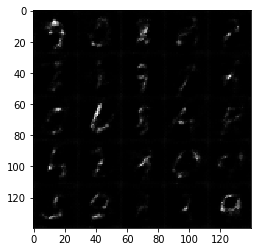

Batch 210/400, Epoch 1/2... Discriminator Loss: 1.3532... Generator Loss: 0.6200
Batch 220/400, Epoch 1/2... Discriminator Loss: 1.2736... Generator Loss: 1.0305
Batch 230/400, Epoch 1/2... Discriminator Loss: 1.3773... Generator Loss: 1.0988
Batch 240/400, Epoch 1/2... Discriminator Loss: 1.2930... Generator Loss: 0.9978
Batch 250/400, Epoch 1/2... Discriminator Loss: 1.3888... Generator Loss: 0.7604
Batch 260/400, Epoch 1/2... Discriminator Loss: 1.3483... Generator Loss: 0.6096
Batch 270/400, Epoch 1/2... Discriminator Loss: 1.3549... Generator Loss: 0.7366
Batch 280/400, Epoch 1/2... Discriminator Loss: 1.3769... Generator Loss: 1.4805
Batch 290/400, Epoch 1/2... Discriminator Loss: 1.2856... Generator Loss: 0.8992
Batch 300/400, Epoch 1/2... Discriminator Loss: 1.4273... Generator Loss: 1.1575


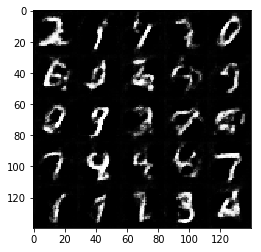

Batch 310/400, Epoch 1/2... Discriminator Loss: 1.3172... Generator Loss: 0.8321
Batch 320/400, Epoch 1/2... Discriminator Loss: 1.3650... Generator Loss: 0.6297
Batch 330/400, Epoch 1/2... Discriminator Loss: 1.2494... Generator Loss: 0.9722
Batch 340/400, Epoch 1/2... Discriminator Loss: 1.5052... Generator Loss: 1.3163
Batch 350/400, Epoch 1/2... Discriminator Loss: 1.3277... Generator Loss: 1.0169
Batch 360/400, Epoch 1/2... Discriminator Loss: 1.3303... Generator Loss: 1.1119
Batch 370/400, Epoch 1/2... Discriminator Loss: 1.2952... Generator Loss: 1.0169
Batch 380/400, Epoch 1/2... Discriminator Loss: 1.3467... Generator Loss: 0.6842
Batch 390/400, Epoch 1/2... Discriminator Loss: 1.3289... Generator Loss: 0.6476
Batch 400/400, Epoch 1/2... Discriminator Loss: 1.2804... Generator Loss: 1.0365


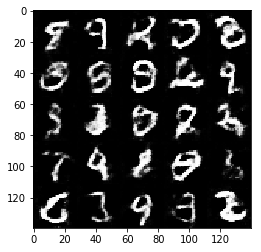

Batch 10/400, Epoch 2/2... Discriminator Loss: 1.3231... Generator Loss: 0.9793
Batch 20/400, Epoch 2/2... Discriminator Loss: 1.3531... Generator Loss: 1.1491
Batch 30/400, Epoch 2/2... Discriminator Loss: 1.4187... Generator Loss: 1.1143
Batch 40/400, Epoch 2/2... Discriminator Loss: 1.3193... Generator Loss: 0.8229
Batch 50/400, Epoch 2/2... Discriminator Loss: 1.3494... Generator Loss: 0.6770
Batch 60/400, Epoch 2/2... Discriminator Loss: 1.3570... Generator Loss: 0.9351
Batch 70/400, Epoch 2/2... Discriminator Loss: 1.4488... Generator Loss: 0.5020
Batch 80/400, Epoch 2/2... Discriminator Loss: 1.3848... Generator Loss: 0.6048
Batch 90/400, Epoch 2/2... Discriminator Loss: 1.2952... Generator Loss: 0.8139
Batch 100/400, Epoch 2/2... Discriminator Loss: 1.3021... Generator Loss: 1.2584


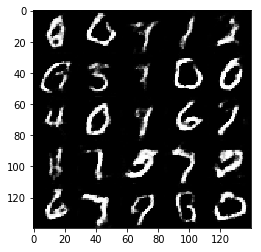

Batch 110/400, Epoch 2/2... Discriminator Loss: 1.3719... Generator Loss: 1.0436
Batch 120/400, Epoch 2/2... Discriminator Loss: 1.3663... Generator Loss: 1.0827
Batch 130/400, Epoch 2/2... Discriminator Loss: 1.3871... Generator Loss: 1.0266
Batch 140/400, Epoch 2/2... Discriminator Loss: 1.3233... Generator Loss: 0.8036
Batch 150/400, Epoch 2/2... Discriminator Loss: 1.2898... Generator Loss: 1.0207
Batch 160/400, Epoch 2/2... Discriminator Loss: 1.3260... Generator Loss: 0.8241
Batch 170/400, Epoch 2/2... Discriminator Loss: 1.3128... Generator Loss: 0.7360
Batch 180/400, Epoch 2/2... Discriminator Loss: 1.3245... Generator Loss: 0.6882
Batch 190/400, Epoch 2/2... Discriminator Loss: 1.3312... Generator Loss: 0.8288
Batch 200/400, Epoch 2/2... Discriminator Loss: 1.2795... Generator Loss: 0.8352


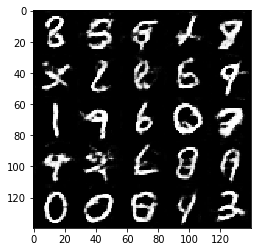

Batch 210/400, Epoch 2/2... Discriminator Loss: 1.3491... Generator Loss: 1.1553
Batch 220/400, Epoch 2/2... Discriminator Loss: 1.2825... Generator Loss: 1.0368
Batch 230/400, Epoch 2/2... Discriminator Loss: 1.3658... Generator Loss: 1.2096
Batch 240/400, Epoch 2/2... Discriminator Loss: 1.3604... Generator Loss: 1.3208
Batch 250/400, Epoch 2/2... Discriminator Loss: 1.3243... Generator Loss: 1.0376
Batch 260/400, Epoch 2/2... Discriminator Loss: 1.3237... Generator Loss: 0.8085
Batch 270/400, Epoch 2/2... Discriminator Loss: 1.3802... Generator Loss: 0.9252
Batch 280/400, Epoch 2/2... Discriminator Loss: 1.3279... Generator Loss: 0.7166
Batch 290/400, Epoch 2/2... Discriminator Loss: 1.3801... Generator Loss: 1.2459
Batch 300/400, Epoch 2/2... Discriminator Loss: 1.3157... Generator Loss: 0.7444


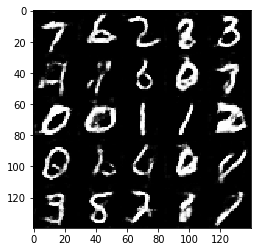

Batch 310/400, Epoch 2/2... Discriminator Loss: 1.2851... Generator Loss: 0.8147
Batch 320/400, Epoch 2/2... Discriminator Loss: 1.3031... Generator Loss: 0.9587
Batch 330/400, Epoch 2/2... Discriminator Loss: 1.4331... Generator Loss: 0.4937
Batch 340/400, Epoch 2/2... Discriminator Loss: 1.3018... Generator Loss: 0.7225
Batch 350/400, Epoch 2/2... Discriminator Loss: 1.3472... Generator Loss: 0.6247
Batch 360/400, Epoch 2/2... Discriminator Loss: 1.2713... Generator Loss: 1.0319
Batch 370/400, Epoch 2/2... Discriminator Loss: 1.2812... Generator Loss: 1.0616
Batch 380/400, Epoch 2/2... Discriminator Loss: 1.2721... Generator Loss: 0.8015
Batch 390/400, Epoch 2/2... Discriminator Loss: 1.4191... Generator Loss: 0.5463
Batch 400/400, Epoch 2/2... Discriminator Loss: 1.2653... Generator Loss: 0.7753


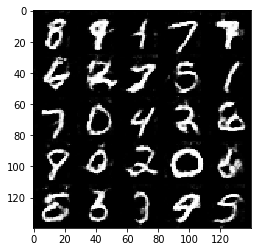

In [105]:
# In the 2016 ICLR conference paper entitled "Unsupervised Representational
# Learning with Deep Convolutional Generative Adversarial Networks", authors
# Radford, Metz, and Chintala introduce DCGANs to the literature, and provide
# guidance on architectural topology and hyperparameter settings.
# See especially Sections 3 and 4 of the paper. Radford et al. say that
# the suggested learning rate of 0.001 was too high, and used 0.0002 instead.
# They also found that leaving the momentum term BETA1 at the suggested value
# of 0.9 resulted in training oscillation and instability, while reducing it
# to 0.5 helped stabilize training.
batch_size = 150
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

############################################################
Optimizing the generator twice as often as the discriminator
############################################################
Batch 10/675, Epoch 1/1... Discriminator Loss: 1.8925... Generator Loss: 0.6216
Batch 20/675, Epoch 1/1... Discriminator Loss: 2.3249... Generator Loss: 0.3889
Batch 30/675, Epoch 1/1... Discriminator Loss: 1.9065... Generator Loss: 0.6878
Batch 40/675, Epoch 1/1... Discriminator Loss: 2.0602... Generator Loss: 0.4744
Batch 50/675, Epoch 1/1... Discriminator Loss: 1.9912... Generator Loss: 0.4085
Batch 60/675, Epoch 1/1... Discriminator Loss: 1.9317... Generator Loss: 0.4484
Batch 70/675, Epoch 1/1... Discriminator Loss: 1.8246... Generator Loss: 0.5534
Batch 80/675, Epoch 1/1... Discriminator Loss: 1.7049... Generator Loss: 0.6733
Batch 90/675, Epoch 1/1... Discriminator Loss: 1.7014... Generator Loss: 0.6744
Batch 100/675, Epoch 1/1... Discriminator Loss: 1.6793... Generator Loss: 0.6626


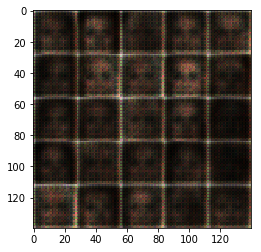

Batch 110/675, Epoch 1/1... Discriminator Loss: 1.5660... Generator Loss: 0.7353
Batch 120/675, Epoch 1/1... Discriminator Loss: 1.6022... Generator Loss: 0.7784
Batch 130/675, Epoch 1/1... Discriminator Loss: 1.5781... Generator Loss: 0.6981
Batch 140/675, Epoch 1/1... Discriminator Loss: 1.6065... Generator Loss: 0.6938
Batch 150/675, Epoch 1/1... Discriminator Loss: 1.6590... Generator Loss: 0.6255
Batch 160/675, Epoch 1/1... Discriminator Loss: 1.6379... Generator Loss: 0.6461
Batch 170/675, Epoch 1/1... Discriminator Loss: 1.5727... Generator Loss: 0.6641
Batch 180/675, Epoch 1/1... Discriminator Loss: 1.5438... Generator Loss: 0.6986
Batch 190/675, Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.7883
Batch 200/675, Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.7882


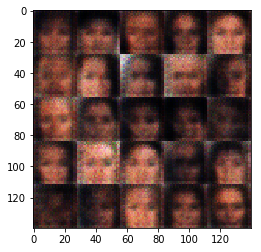

Batch 210/675, Epoch 1/1... Discriminator Loss: 1.5259... Generator Loss: 0.7412
Batch 220/675, Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.7496
Batch 230/675, Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.8040
Batch 240/675, Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7762
Batch 250/675, Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.8579
Batch 260/675, Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7643
Batch 270/675, Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7782
Batch 280/675, Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.7461
Batch 290/675, Epoch 1/1... Discriminator Loss: 1.5524... Generator Loss: 0.7868
Batch 300/675, Epoch 1/1... Discriminator Loss: 1.6678... Generator Loss: 0.6704


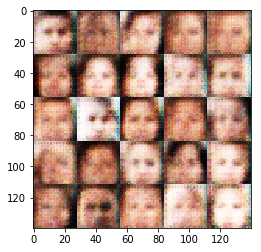

Batch 310/675, Epoch 1/1... Discriminator Loss: 1.5887... Generator Loss: 0.7067
Batch 320/675, Epoch 1/1... Discriminator Loss: 1.5463... Generator Loss: 0.7080
Batch 330/675, Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.7103
Batch 340/675, Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.7981
Batch 350/675, Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.7741
Batch 360/675, Epoch 1/1... Discriminator Loss: 1.5411... Generator Loss: 0.7142
Batch 370/675, Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.7483
Batch 380/675, Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.7548
Batch 390/675, Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.7394
Batch 400/675, Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 0.7453


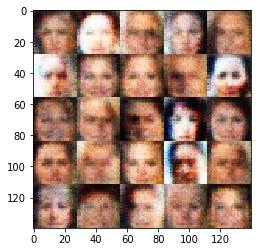

Batch 410/675, Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.7446
Batch 420/675, Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.7785
Batch 430/675, Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.7227
Batch 440/675, Epoch 1/1... Discriminator Loss: 1.5069... Generator Loss: 0.7454
Batch 450/675, Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.7474
Batch 460/675, Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.7606
Batch 470/675, Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.7497
Batch 480/675, Epoch 1/1... Discriminator Loss: 1.5010... Generator Loss: 0.7509
Batch 490/675, Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7590
Batch 500/675, Epoch 1/1... Discriminator Loss: 1.5268... Generator Loss: 0.7814


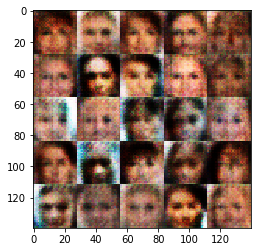

Batch 510/675, Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.7703
Batch 520/675, Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.7457
Batch 530/675, Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.7863
Batch 540/675, Epoch 1/1... Discriminator Loss: 1.5121... Generator Loss: 0.7324
Batch 550/675, Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.7523
Batch 560/675, Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.7918
Batch 570/675, Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.7730
Batch 580/675, Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7837
Batch 590/675, Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.7765
Batch 600/675, Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7905


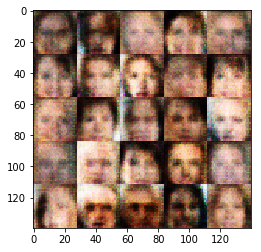

Batch 610/675, Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.8101
Batch 620/675, Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.7375
Batch 630/675, Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.7254
Batch 640/675, Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7997
Batch 650/675, Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.8112
Batch 660/675, Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.7609
Batch 670/675, Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.7348


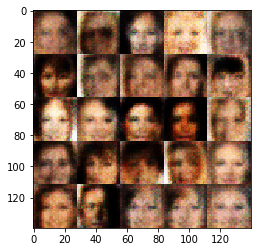

In [106]:
# In the 2016 ICLR conference paper entitled "Unsupervised Representational
# Learning with Deep Convolutional Generative Adversarial Networks", authors
# Radford, Metz, and Chintala introduce DCGANs to the literature, and provide
# guidance on architectural topology and hyperparameter settings.
# See especially Sections 3 and 4 of the paper. Radford et al. say that
# the suggested learning rate of 0.001 was too high, and used 0.0002 instead.
# They also found that leaving the momentum term BETA1 at the suggested value
# of 0.9 resulted in training oscillation and instability, while reducing it
# to 0.5 helped stabilize training.
batch_size = 300
z_dim = 200 # Try a longer random vector for the CelebA face data.
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.